# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide  


reference)  
[1] https://github.com/dvgodoy/PyTorchStepByStep  
[2] https://codetorial.net/tensorflow/classifying_the_cats_and_dogs.html

# Convolution에 대한 이해

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter5()
# This is needed to render the plots in this chapter
from plots.chapter5 import *

Finished!


In [ ]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn  #별도로 인스턴스화 해야 사용 가능(클래스를 이용하여 모델을 정의)
import torch.nn.functional as F #인스턴스화 필요 없이 사용이 가능(별도의 변수 선언 없이 바로 사용)

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

# from data_generation.image_classification import generate_dataset
# from helpers import index_splitter, make_balanced_sampler
# from stepbystep.v1 import StepByStep

# Convolutions

## Filter / Kernel

![](./images/conv1.png)

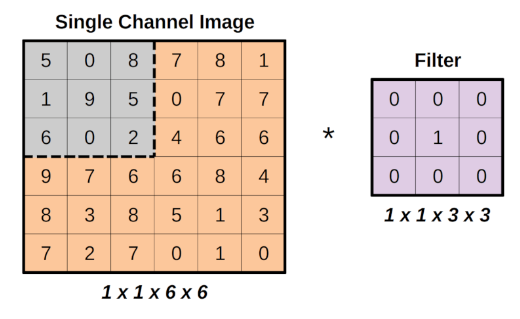

In [ ]:
single = np.array(
    [[[[5, 0, 8, 7, 8, 1],
       [1, 9, 5, 0, 7, 7],
       [6, 0, 2, 4, 6, 6],
       [9, 7, 6, 6, 8, 4],
       [8, 3, 8, 5, 1, 3],
       [7, 2, 7, 0, 1, 0]]]]
)
single.shape

(1, 1, 6, 6)

In [ ]:
identity = np.array(
    [[[[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]]]]
)
identity.shape

(1, 1, 3, 3)

## Convolving

![](./images/conv2.png)

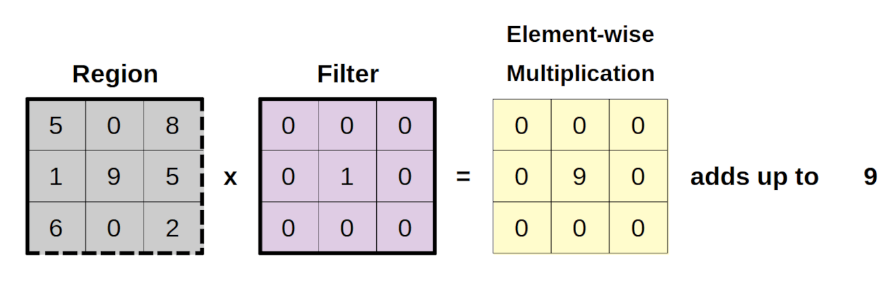

In [ ]:
region = single[:, :, 0:3, 0:3]
filtered_region = region * identity
total = filtered_region.sum()
total

9

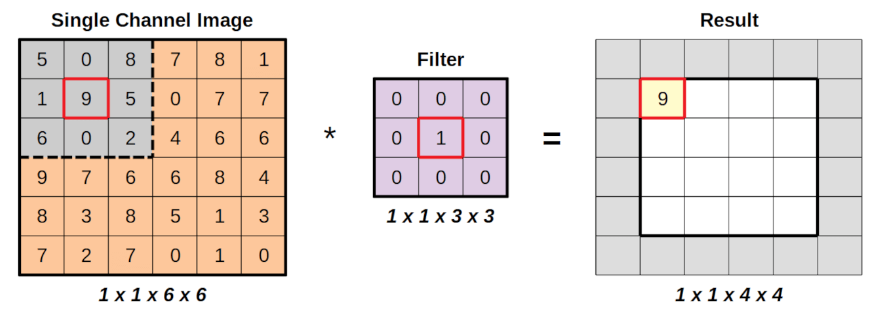

![](./images/conv3.png)

## Moving Around

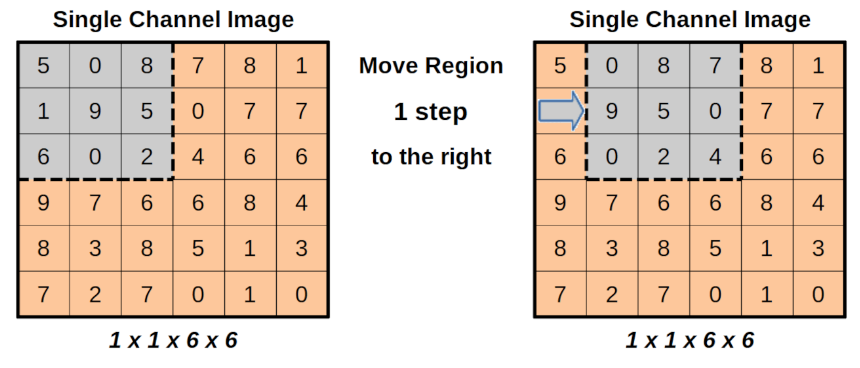

In [ ]:
new_region = single[:, :, 0:3, (0+1):(3+1)]

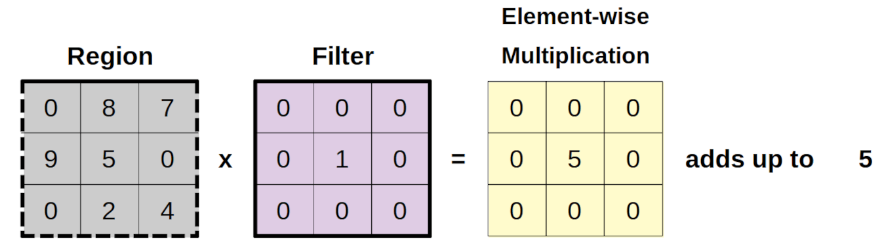

![](./images/conv5.png)

In [ ]:
new_filtered_region = new_region * identity
new_total = new_filtered_region.sum()
new_total

5

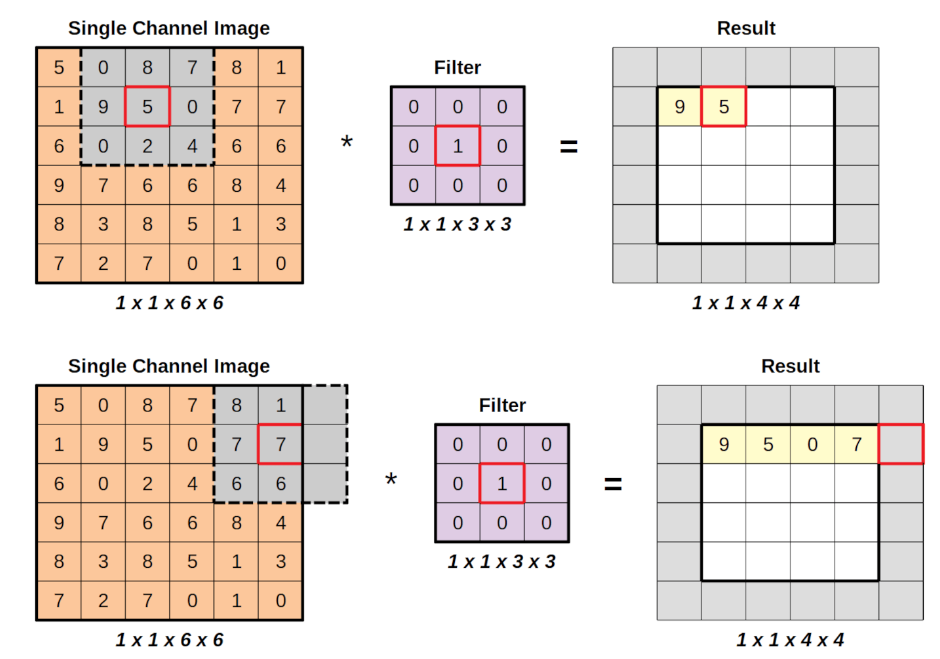

![](./images/conv6.png)

![](./images/conv7.png)

In [ ]:
last_horizontal_region = single[:, :, 0:3, (0+4):(3+4)]

In [ ]:
last_horizontal_region * identity   # Q1. 에러가 나는 케이스, 에러의 이유는 ?

ValueError: ignored

## Shape

![](./images/conv8.png)

$$
\Large
(h_i, w_i) * (h_f, w_f) = (h_i - (h_f - 1), w_i - (w_f - 1))
$$

$$
\Large
(h_i, w_i) * f = (h_i - f + 1, w_i - f + 1)
$$

## Convolving in PyTorch

In [ ]:
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

In [ ]:
image

tensor([[[[5., 0., 8., 7., 8., 1.],
          [1., 9., 5., 0., 7., 7.],
          [6., 0., 2., 4., 6., 6.],
          [9., 7., 6., 6., 8., 4.],
          [8., 3., 8., 5., 1., 3.],
          [7., 2., 7., 0., 1., 0.]]]])

In [ ]:
kernel_identity

tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]])

In [ ]:
convolved = F.conv2d(image, kernel_identity, stride=1)  #예상되는 이미지의 차원 ((input - filter)/1 + 1, (input - filter)/1 + 1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

In [ ]:
image.shape

torch.Size([1, 1, 6, 6])

In [ ]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)  #출력 채널을 1로 하고 싶으면 out_channels = 1
conv(image) #6x6 이미지를 3x3 필터에 적용하여 convolution 통과 결과

tensor([[[[3.8668, 5.6034, 4.2299, 2.8174],
          [4.0026, 0.4161, 1.6162, 5.2129],
          [1.8766, 2.9165, 5.2362, 5.3843],
          [4.7965, 4.5310, 5.6773, 4.3334]]]], grad_fn=<ConvolutionBackward0>)

In [ ]:
conv_multiple = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1) #출력 채널을 2로 하고 싶으면 out_channels = 2 -> filter를 2개 사용
conv_multiple.weight

Parameter containing:
tensor([[[[ 0.1391,  0.0858,  0.0009],
          [-0.2257,  0.2704,  0.0295],
          [-0.2964, -0.0309, -0.1116]]],


        [[[-0.2451,  0.0711, -0.3262],
          [ 0.0605,  0.2336,  0.2156],
          [-0.2920,  0.0663, -0.1872]]]], requires_grad=True)

In [ ]:
#가중치 및 편향을 초기화 하는 방법
with torch.no_grad():
    conv.weight[0] = kernel_identity
    conv.bias[0] = 0

In [ ]:
conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

## Striding

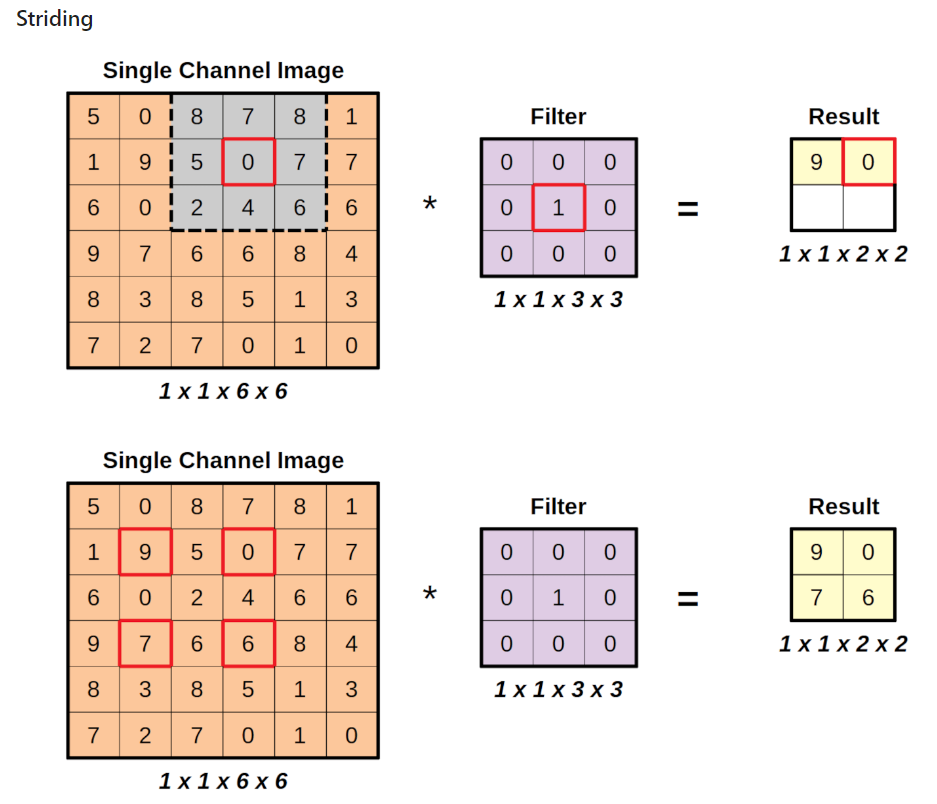

![](./images/strider2.png)

![](./images/strider3.png)

$$
\Large
(h_i, w_i) * f = \left(\frac{h_i - f + 1}{s}, \frac{w_i - f + 1}{s}\right)
$$

In [ ]:
convolved_stride2 = F.conv2d(image, kernel_identity,   stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

## Padding

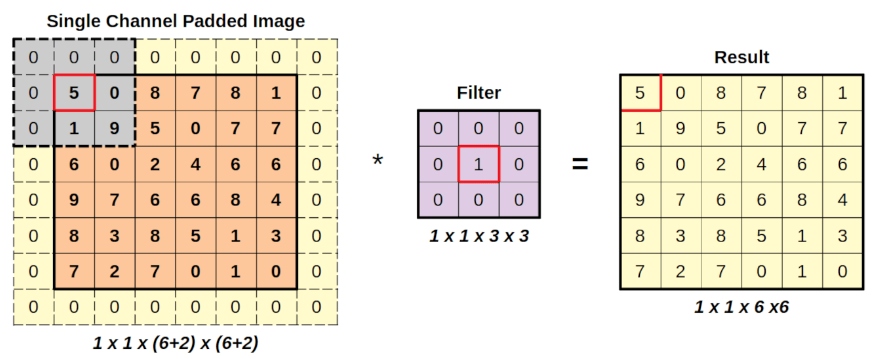

![](./images/padding1.png)

In [ ]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [ ]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode='constant', value=0)

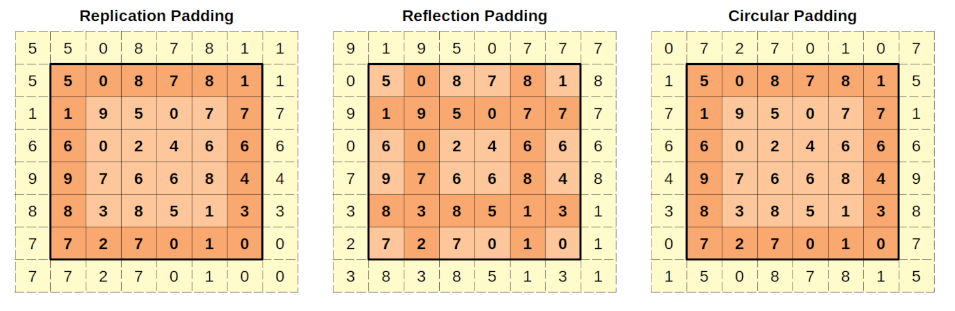

![](images/paddings.png)

In [ ]:
padded

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [ ]:
replication_padder = nn.ReplicationPad2d(padding=1) #경계 복제 패딩
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In [ ]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

$$
\Large
(h_i, w_i) * f = \left(\frac{(h_i + 2p) - f}{s}+1, \frac{(w_i + 2p) - f}{s}+1\right)
$$

## A REAL Filter

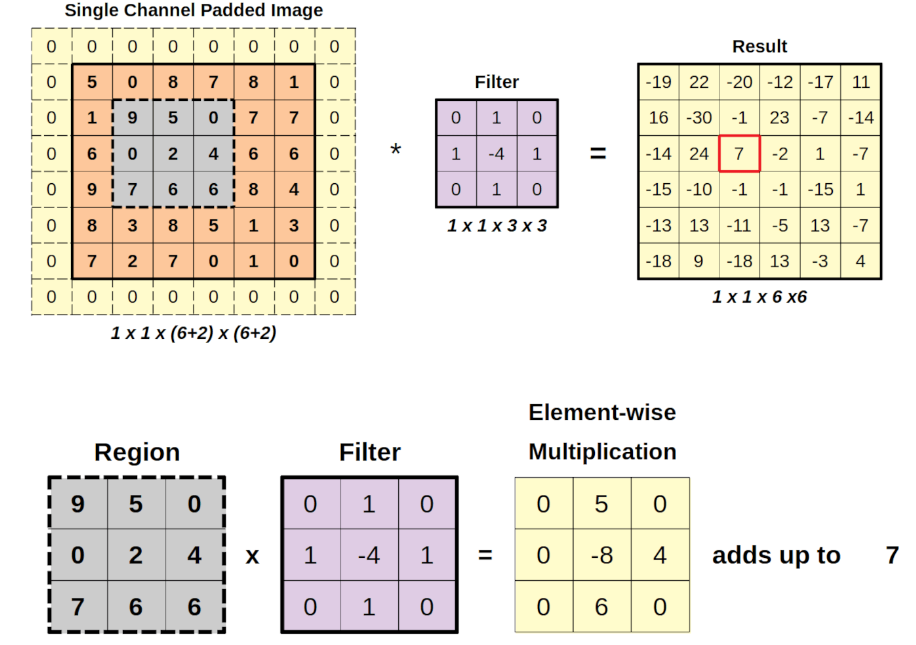

In [ ]:
edge = np.array(
    [[[[0, 1, 0],
       [1, -4, 1],
       [0, 1, 0]]]]
)
kernel_edge = torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

![](./images/padding2.png)

![](./images/padding3.png)

In [ ]:
#이미지에 패딩을 씌우고 conv 통과
padded = F.pad(image, (1, 1, 1, 1), mode='constant', value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)

In [ ]:
conv_padded # 입력 이미지와 같은 이미지 출력, Q.이렇게 하는 이유는?

tensor([[[[-19.,  22., -20., -12., -17.,  11.],
          [ 16., -30.,  -1.,  23.,  -7., -14.],
          [-14.,  24.,   7.,  -2.,   1.,  -7.],
          [-15., -10.,  -1.,  -1., -15.,   1.],
          [-13.,  13., -11.,  -5.,  13.,  -7.],
          [-18.,   9., -18.,  13.,  -3.,   4.]]]])

# Pooling

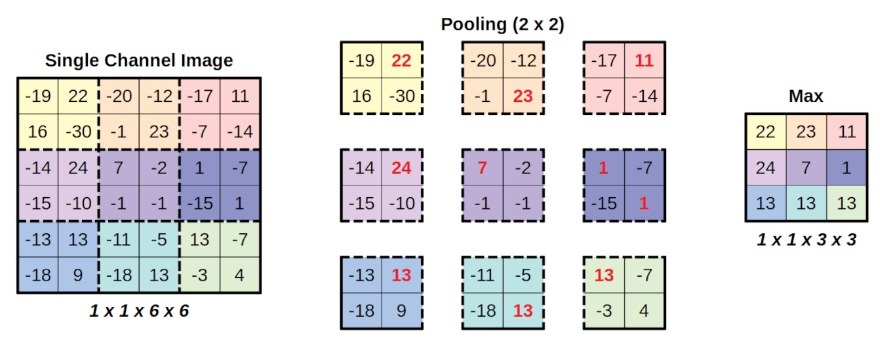

![](./images/pooling1.png)

In [ ]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [ ]:
maxpool4 = nn.MaxPool2d(kernel_size=3)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24., 23.],
          [13., 13.]]]])

In [ ]:
F.max_pool2d(conv_padded, kernel_size=3, stride=1) #풀링 연산에 stride 적용

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

# Flattening

In [ ]:
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [ ]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [ ]:
pooled.view(1, -1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

# Typical Architecture

## LeNet5

- LeNet은 CNN을 처음으로 개발한 얀 르쿤(Yann Lecun) 연구팀이 1998년에 개발한 CNN 알고리즘의 이름  
- original 논문 제목은 "Gradient-based learning applied to document recognition"  
-LeNet-5의 구조는 아래와 같음

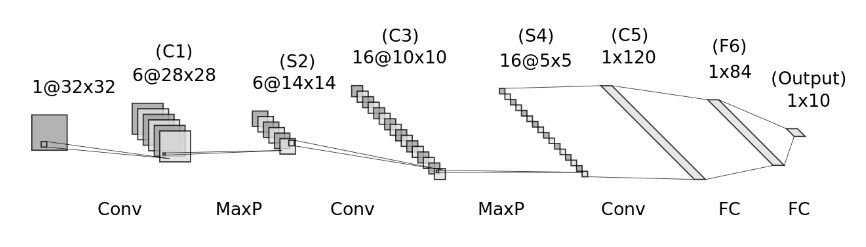

![](images/architecture_lenet.png)

*Source: Generated using Alexander Lenail's [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author. For more details, see LeCun, Y., et al (1998).  [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Proceedings of the IEEE,86(11), 2278–2324*

In [ ]:
lenet = nn.Sequential()

# Featurizer
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
"""C1 layer step : 32x32 이미지를 6개의 5x5 필터와 컨볼루션 연산을 진행(32-5+1, 32-5+1)
   S2 layer step : 6장의 28x28 feature map에 대해 2x2 Maxpooling -> 6장의 14x14 """

lenet.add_module('C1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)) #훈련해야할 파라미터 개수: (가중치*입력맵개수*채널 수 + 바이어스)*특성맵개수 = (5*5*1 + 1)*6 = 156
lenet.add_module('func1', nn.ReLU())
lenet.add_module('S2', nn.MaxPool2d(kernel_size=2))

# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
"""C2 layer step : 14x14 이미지를 16개의 5x5 필터와 컨볼루션 연산을 진행(14-5+1, 14-5+1)
   S4 layer step : 16장의 10x10 feature map에 대해 2x2 Maxpooling -> 16장의 5x5 """
lenet.add_module('C3', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)) #훈련해야할 파라미터 개수: (가중치*입력맵개수*채널 수 + 바이어스)*특성맵개수 = (5*5*6 + 1)*16 = 2416
lenet.add_module('func2', nn.ReLU())
lenet.add_module('S4', nn.MaxPool2d(kernel_size=2))


# Block 3: 16@5x5 -> 120@1x1
"""C5 layer step : 5x5 이미지를 120개의 5x5 필터와 컨볼루션 연산을 진행(5-5+1, 5-5+1) """
lenet.add_module('C5', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)) #훈련해야할 파라미터 개수: (가중치*입력맵개수*채널 수 + 바이어스)*특성맵개수 = (5*5*16 + 1)*120 = 48120
lenet.add_module('func2', nn.ReLU())
# Flattening
lenet.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
lenet.add_module('F6', nn.Linear(in_features=120, out_features=84))
lenet.add_module('func3', nn.ReLU())
# Output Layer
lenet.add_module('OUTPUT', nn.Linear(in_features=84, out_features=10))

print('훈련해야 할 파라미터의 갯수:', 156+2416+48120)

훈련해야 할 파라미터의 갯수: 50692


## CNN으로 고양이 강아지 분류하기

In [ ]:
#다운로드
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

--2023-02-20 05:52:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  21.0MB/s    in 3.9s    

2023-02-20 05:52:27 (16.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
#압출풀기
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# 기본 경로
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련에 사용되는 고양이/개 이미지 경로
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_cats_dir)
print(train_dogs_dir)

# 테스트에 사용되는 고양이/개 이미지 경로
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_cats_dir)
print(validation_dogs_dir)

/tmp/cats_and_dogs_filtered/train/cats
/tmp/cats_and_dogs_filtered/train/dogs
/tmp/cats_and_dogs_filtered/validation/cats
/tmp/cats_and_dogs_filtered/validation/dogs


In [ ]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:5])
print(train_dog_fnames[:5])

['cat.89.jpg', 'cat.190.jpg', 'cat.424.jpg', 'cat.78.jpg', 'cat.802.jpg']
['dog.673.jpg', 'dog.963.jpg', 'dog.868.jpg', 'dog.791.jpg', 'dog.180.jpg']


In [ ]:
print('Total training cat images :', len(os.listdir(train_cats_dir)))
print('Total training dog images :', len(os.listdir(train_dogs_dir)))

print('Total validation cat images :', len(os.listdir(validation_cats_dir)))
print('Total validation dog images :', len(os.listdir(validation_dogs_dir)))

Total training cat images : 1000
Total training dog images : 1000
Total validation cat images : 500
Total validation dog images : 500


이미지 확인하기

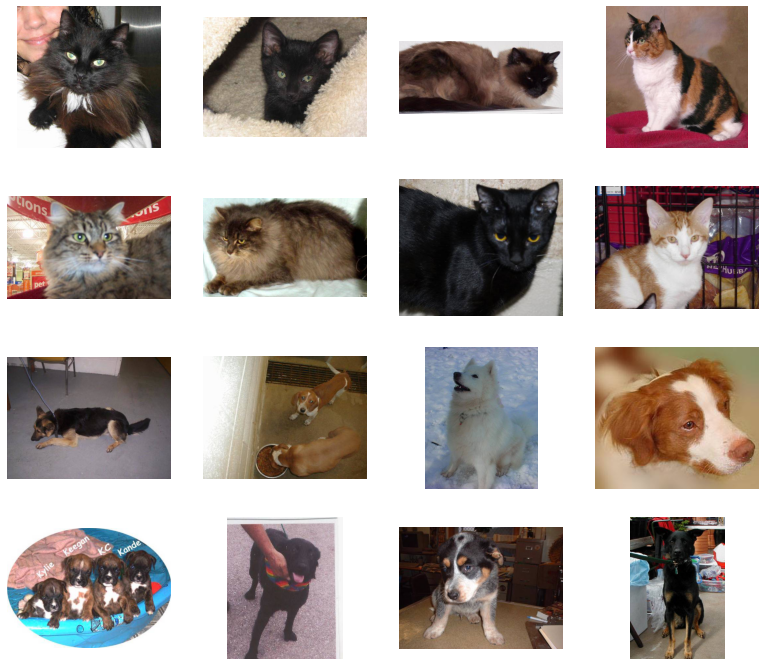

In [ ]:
%matplotlib inline #코드를 입력한 셀 밑에 그래프가 바로 출력되게

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
validation_dir

'/tmp/cats_and_dogs_filtered/validation'

In [ ]:
# Coding
import torch
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# batch size
batch_size = 10

# 이미지 전처리
train_transforms = transforms.Compose([transforms.RandomRotation(30), # 랜덤 각도 회전
                                       transforms.RandomResizedCrop(224), # 랜덤 리사이즈 크롭
                                       transforms.RandomHorizontalFlip(), # 랜덤으로 수평 뒤집기
                                       transforms.ToTensor(),# 이미지를 텐서로
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # RGB 모든 픽셀을 0.5로 나눈 뒤 0.5로 뺌

test_transforms = transforms.Compose([transforms.Resize((224, 224)),# 이미지 리사이즈
                                      transforms.ToTensor(), # 이미지를 텐서로
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# training, validation, testset 로드
trainset = ImageFolder(root='/tmp/cats_and_dogs_filtered/train', transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

validset = ImageFolder(root='/tmp/cats_and_dogs_filtered/validation', transform=train_transforms)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)


# cat dog 클래스 분류
classes = ['cat', 'dog']

print(len(trainset))
print(len(validset))

2000
1000


In [ ]:
trainset.classes #ImageFolder -> 디렉토리 파일 명을 클래스로 사용할 수 있도록 되어 있음

['cats', 'dogs']

In [ ]:
validset.classes

['cats', 'dogs']

(10, 3, 224, 224)


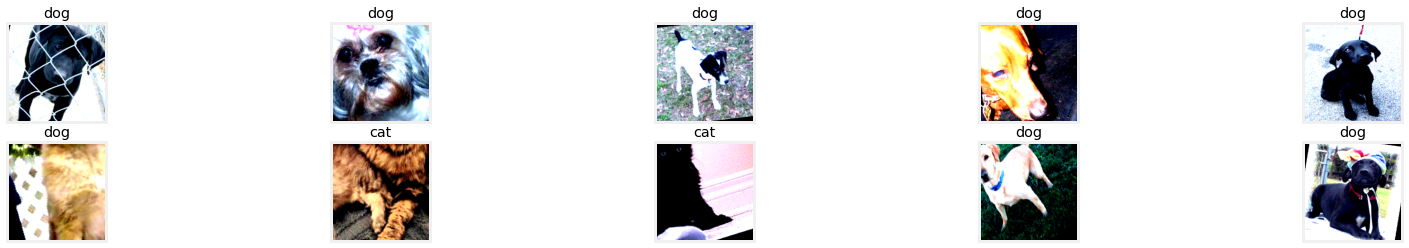

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", message="Clipping input data to the valid range for imshow with RGB data")

def imshow(img):
    img = img * 0.5 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

print(images.shape)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# 코드 작성
import torch.nn as nn
import torch.nn.functional as F

# CNN 작성
class ConvNet(nn.Module):
    def __init__(self):
      super(ConvNet, self).__init__()

      # input image = 224 x 244 x 3


      self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # (I + 2P - K)/S + 1 -> (224 + 2 - 3)/1 + 1 = 224

      self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

      self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

      self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

      # maxpool 2 x 2
      self.pool = nn.MaxPool2d(2, 2)

      # 28 x 28 x 128 vector flat 512개
      self.fc1 = nn.Linear(256 * 14 * 14, 512)
      # 카테고리 2개 클래스
      self.fc2 = nn.Linear(512, 2)

      # dropout 적용
      self.dropout = nn.Dropout(0.5)

    def forward(self, x):

      x = self.pool(F.relu(self.conv1(x))) # conv -> (I + 2P - K)/S + 1 -> (224 + 2 - 3)/1 + 1 = 224 -> MAX pooling 2x2 -> 112

      x = self.pool(F.relu(self.conv2(x))) # conv -> (I + 2P - K)/S + 1 -> (112 + 2 - 3)/1 + 1 = 112 -> MAX pooling 2x2 -> 56

      x = self.pool(F.relu(self.conv3(x))) # conv -> (I + 2P - K)/S + 1 -> (56 + 2 - 3)/1 + 1 = 56 -> MAX pooling 2x2 -> 28

      x = self.pool(F.relu(self.conv4(x))) # conv -> (I + 2P - K)/S + 1 -> (28 + 2 - 3)/1 + 1 = 28 -> MAX pooling 2x2 -> 14

      # 이미지 펴기
      x = x.view(-1, 256 * 14 * 14) #(-1, CxHxW)
      # dropout 적용
      x = self.dropout(x)
      # fc 레이어에 삽입 후 relu
      x = F.relu(self.fc1(x))
      # dropout 적용
      x = self.dropout(x)

      # 마지막 logsoftmax 적용 -> 확률값 생성
      x = F.log_softmax(self.fc2(x), dim=1)
      return x

model = ConvNet().to(device) # 모델 생성
print(model) # 출력

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch.optim as optim

criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
model = ConvNet()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('model_catdog.pt',map_location=device))

In [ ]:
n_epochs = 30

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):
    # train, valid loss
    train_loss = 0.0
    valid_loss = 0.0

    # 모델 트레이닝
    model.train()
    # training set
    for data, target in trainloader:
      data = data.to(device)
      target = target.to(device)

      # 역전파 실행 전 gradient 0 초기화
      optimizer.zero_grad()
      # 모델 계산 후 output 저장
      output = model(data)
      # 로스율 계산
      loss = criterion(output, target)
      # 가중치 계산
      loss.backward()
      # 모델 parameter 업데이트
      optimizer.step()
      # 트레이닝 로스 계산
      train_loss += loss.item()*data.size(0)

    # validation 모델
    model.eval()
    with torch.no_grad():
      validation_iter = iter(validloader)
      for data, target in validation_iter:
        data = data.to(device)
        target = target.to(device)

        # 모델 계산 후 output 저장
        output = model(data)
        # 로스율 계산
        loss = criterion(output, target)
        # validation 로스율 계산
        valid_loss += loss.item()*data.size(0)

    # 평균 로스율
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)

    # training set, validation set 로스율 출력
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # 로스율이 낮아지면 model_catdog.pt에 저장
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_catdog.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.693329 	Validation Loss: 0.688654
Validation loss decreased (inf --> 0.688654).  Saving model ...
Epoch: 2 	Training Loss: 0.689419 	Validation Loss: 0.682487
Validation loss decreased (0.688654 --> 0.682487).  Saving model ...
Epoch: 3 	Training Loss: 0.685354 	Validation Loss: 0.673570
Validation loss decreased (0.682487 --> 0.673570).  Saving model ...
Epoch: 4 	Training Loss: 0.676937 	Validation Loss: 0.662255
Validation loss decreased (0.673570 --> 0.662255).  Saving model ...
Epoch: 5 	Training Loss: 0.670341 	Validation Loss: 0.647712
Validation loss decreased (0.662255 --> 0.647712).  Saving model ...
Epoch: 6 	Training Loss: 0.657949 	Validation Loss: 0.643818
Validation loss decreased (0.647712 --> 0.643818).  Saving model ...
Epoch: 7 	Training Loss: 0.655769 	Validation Loss: 0.633450
Validation loss decreased (0.643818 --> 0.633450).  Saving model ...
Epoch: 8 	Training Loss: 0.647795 	Validation Loss: 0.632508
Validation loss decreased (0.63345

In [ ]:
# 최소 로스율 모델 로딩
model.load_state_dict(torch.load('model_catdog.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()

for data, target in validloader:
  data = data.to(device)
  target = target.to(device)

  # 데이터를 output에 삽입
  output = model(data)
  # loss율 계산
  loss = criterion(output, target)
  # loss율 업데이트
  test_loss += loss.item()*data.size(0)
  # 1차원, 정답률 확인
  _, pred = torch.max(output, 1)
  # pred와 데이터를 비교한다
  correct_tensor = pred.eq(target.data.view_as(pred))
  # torrect_tensor를 numpy로 바꾼 뒤 gpu 계산 또는 cpu 계산
  correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())
  # 몇 개 맞췄나 계산
  for i in range(batch_size): # 배치 사이즈로
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

      # batch_size 32 넣으면 index 오류가 발생함. 만약 배치사이즈 32넣을때 강제로 1250장씩 분류하면 중지되도록 설정
      # 평소에는 주석
      #if class_total == [1250.0, 1250.0]:
        #break

# 로스율 평균 계산
test_loss = test_loss/len(validloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    # 각 클래스 별 확률 출력
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# 최종 확률 출력
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.567650

Test Accuracy of   cat: 78% (394/500)
Test Accuracy of   dog: 59% (299/500)

Test Accuracy (Overall): 69% (693/1000)


### 가중치 시각화 하기

In [ ]:
# !pip install grad-cam

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision
from torchvision.models import resnet18, resnet50, resnet152
import torchvision.transforms as transforms # 이미지 변환 툴
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

img_path = "/tmp/cats_and_dogs_filtered/train/dogs/dog.10.jpg" # 찍어보고 싶은 이미지 경로를 지정합니다.

In [ ]:
model.load_state_dict(torch.load('model_catdog.pt'))
model.to(device)

for param in model.parameters():
    param.requires_grad = False

model  #gradient 계산 x, freeze

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

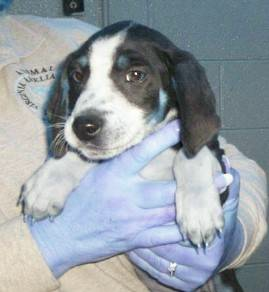

In [ ]:
#원본 이미지 -> 모델이 어디에 집중 했을까?를 알아봅시다. 강아지편
image = cv2.imread(img_path, 1)
Image.fromarray(image[:, :, :3])

292 269 3


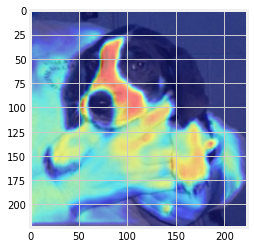

In [ ]:
def get_img_tensor(img_path):
    img = cv2.imread(img_path)
    h, w, c = img.shape
    print(h, w, c)
    img = Image.fromarray(img[:, :, :3])
    img = torchvision.transforms.Resize((224,224))(img)
    img = torchvision.transforms.ToTensor()(img)
    img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
    img = img.unsqueeze(0)
    return img

model = ConvNet()
device = torch.device('cpu')# 연산해줄 device를 선언 해 줍니다. cuda or cpu
model.load_state_dict(torch.load('model_catdog.pt',map_location=device))

target_layers = [model.conv3]# CAM을 찍어볼 모델의 특정 레이어를 리스트 안에 넣어 사용합니다.
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False) # GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad처럼 다양한 툴을 사용할 수 있습니다.

img = get_img_tensor(img_path) # 이미지를 tensor로 변환합니다.
# image = plt.imread(img_path)
image = cv2.imread(img_path, 1)
image = Image.fromarray(image[:, :, :3])
image = np.float32(torchvision.transforms.Resize((224,224))(image)) / 255
output = model(img)
_, pred = torch.max(output, 1) #이미지에 대한 모델 예측값을 받아줍니다.
targets = [ClassifierOutputTarget(pred)] #이미지에 대한 예측값을 target으로 둡니다.

# CAM을 적용해 줍니다.
grayscale_cam = cam(input_tensor=img, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)

코에 많이 집중 했구먼

In [ ]:
img_cat = "/tmp/cats_and_dogs_filtered/train/cats/cat.554.jpg" # 찍어보고 싶은 이미지 경로를 지정합니다.

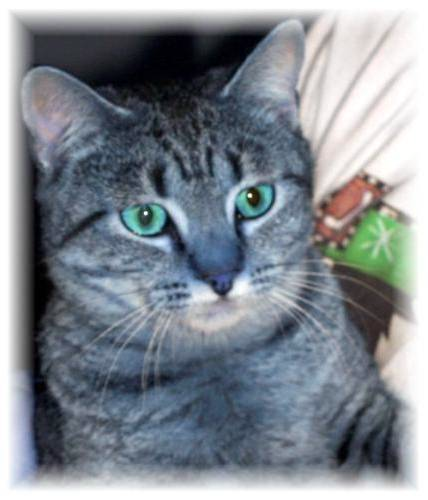

In [ ]:
#원본 이미지 -> 모델이 어디에 집중 했을까?를 알아봅시다. 고양이편
image = cv2.imread(img_cat, 1)
Image.fromarray(image[:, :, :3])

500 428 3


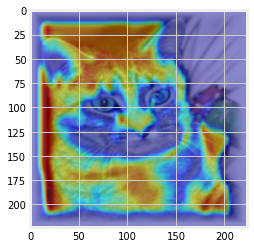

In [ ]:
def get_img_tensor(img_path):
    img = cv2.imread(img_path)
    h, w, c = img.shape
    print(h, w, c)
    img = Image.fromarray(img[:, :, :3])
    img = torchvision.transforms.Resize((224,224))(img)
    img = torchvision.transforms.ToTensor()(img)
    img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
    img = img.unsqueeze(0)
    return img

model = ConvNet()
device = torch.device('cpu')# 연산해줄 device를 선언 해 줍니다. cuda or cpu
model.load_state_dict(torch.load('model_catdog.pt',map_location=device))

target_layers = [model.conv3]# CAM을 찍어볼 모델의 특정 레이어를 리스트 안에 넣어 사용합니다.
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False) # GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad처럼 다양한 툴을 사용할 수 있습니다.

img = get_img_tensor(img_cat) # 이미지를 tensor로 변환합니다.
# image = plt.imread(img_path)
image = cv2.imread(img_cat, 1)
image = Image.fromarray(image[:, :, :3])
image = np.float32(torchvision.transforms.Resize((224,224))(image)) / 255
output = model(img)
_, pred = torch.max(output, 1) #이미지에 대한 모델 예측값을 받아줍니다.
targets = [ClassifierOutputTarget(pred)] #이미지에 대한 예측값을 target으로 둡니다.

# CAM을 적용해 줍니다.
grayscale_cam = cam(input_tensor=img, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)

귀에 집중을 많이 했구먼

In [ ]:
pred

tensor([1])

#### 재헌이형 강아지

In [ ]:
img_jae = "/tmp/재헌이형.jpg"

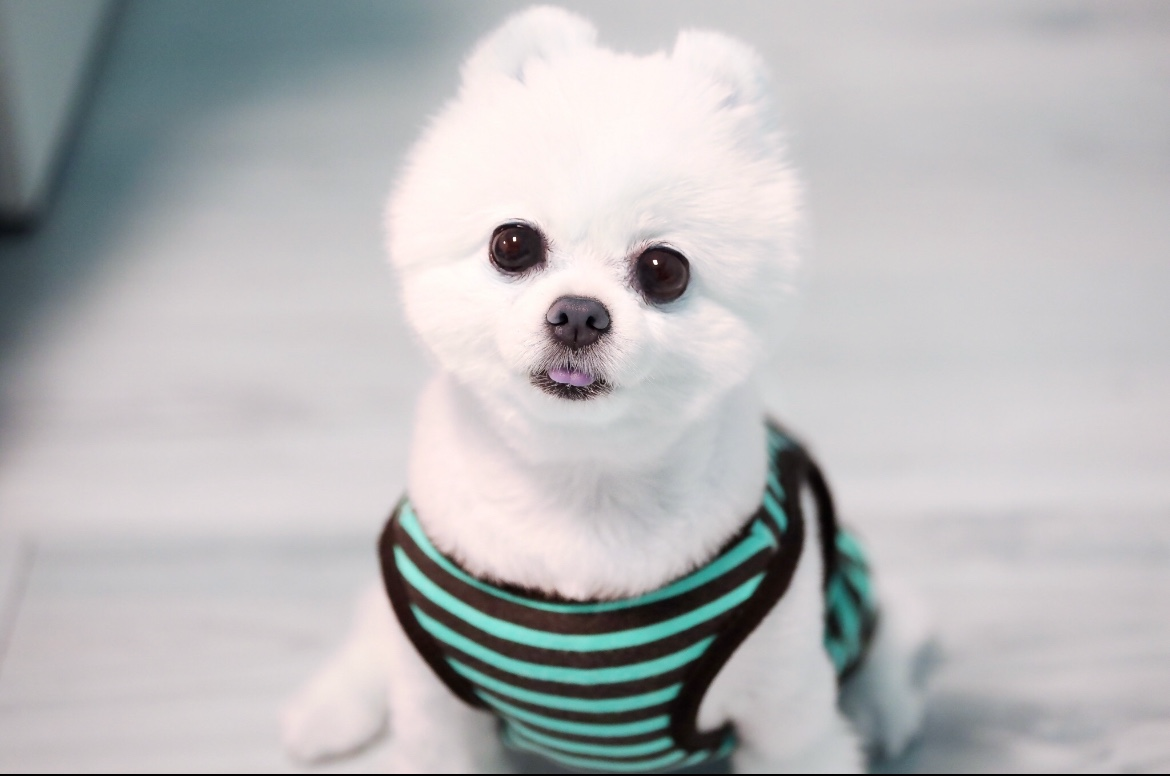

In [ ]:
#원본 이미지 -> 모델이 어디에 집중 했을까?를 알아봅시다. 고양이편
image = cv2.imread(img_jae, 1)
Image.fromarray(image[:, :, :3])

776 1170 3


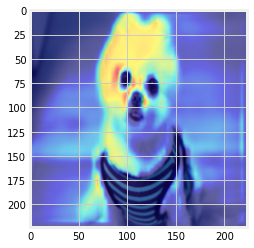

In [ ]:
def get_img_tensor(img_path):
    img = cv2.imread(img_path)
    h, w, c = img.shape
    print(h, w, c)
    img = Image.fromarray(img[:, :, :3])
    img = torchvision.transforms.Resize((224,224))(img)
    img = torchvision.transforms.ToTensor()(img)
    img = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(img)
    img = img.unsqueeze(0)
    return img

model = ConvNet()
device = torch.device('cpu')# 연산해줄 device를 선언 해 줍니다. cuda or cpu
model.load_state_dict(torch.load('model_catdog.pt',map_location=device))

target_layers = [model.conv3]# CAM을 찍어볼 모델의 특정 레이어를 리스트 안에 넣어 사용합니다.
cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False) # GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad처럼 다양한 툴을 사용할 수 있습니다.

img = get_img_tensor(img_jae) # 이미지를 tensor로 변환합니다.
# image = plt.imread(img_path)
image = cv2.imread(img_jae, 1)
image = Image.fromarray(image[:, :, :3])
image = np.float32(torchvision.transforms.Resize((224,224))(image)) / 255
output = model(img)
_, pred = torch.max(output, 1) #이미지에 대한 모델 예측값을 받아줍니다.
targets = [ClassifierOutputTarget(pred)] #이미지에 대한 예측값을 target으로 둡니다.

# CAM을 적용해 줍니다.
grayscale_cam = cam(input_tensor=img, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)

코쪽을 확실히 집중하는 듯

In [ ]:
Q3. (256, 256) 이미지가 있습니다. -> conv를 통과 할건데 -> 원본 이미지랑 같은 사이즈를 출력하고 싶어

(input - kernel + 2*padding)/stride + 1 일 때

stride는 몇이 되어야 하며, kernel과 padding 사이즈의 관계에 대해서 증명하세유

